In [1]:

## if you run in google colab, you need to uncomment the following and download the data and XRO source code to run this notebook

# run_google_colab = True
run_google_colab = False


In [2]:
import importlib.util
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

# Function to check and install a package if not found
def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")

# List of required packages
required_packages = [
    "matplotlib", "numpy", "xarray", "nc-time-axis", "cftime", "climpred", "dateutil", "seaborn",
]

if run_google_colab:
    # Install missing packages if needed
    for pkg in required_packages:
        install_if_missing(pkg)

# Importing libraries after ensuring they are installed
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from climpred import HindcastEnsemble
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator


In [3]:
if run_google_colab:
    # Download necessary files if running in Google Colab
    !wget -cq https://github.com/senclimate/XRO/raw/main/data/XRO_indices_oras5.nc
    !wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO.py
    !wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO_utils.py

# def setup_module_path():
# module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/XRO-main'
# sys.path.append(module_path)

# Import necessary modules after ensuring files are available
from XRO import XRO, xcorr, SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm
# from XRO_utils import SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm

print("All required libraries are installed and imported successfully!")

All required libraries are installed and imported successfully!


In [25]:
# load observed state vectors of XRO: which include ENSO, WWV, and other modes SST indices
# the order of variables is important, with first two must be ENSO SST and WWV;
if run_google_colab:
    obs_file = './XRO_indices_oras5.nc'
else:
    # obs_file = '../data/XRO_indices_oras5.nc'
    obs_file = '/mnt/lustre/proj/kimyy/Dropbox/source/python/all/Modules/RO_practical-main/data/XRO_indices_oras5.nc'
    obs_file2 = '/mnt/lustre/proj/kimyy/Dropbox/source/python/all/Modules/RO_practical-main/data/indices_oras5.nc'

obs_ds = xr.open_dataset(obs_file).sel(time=slice('1979-01', '2024-12'))
obs_ds2 = xr.open_dataset(obs_file2).sel(time=slice('1979-01', '2024-12'))

# obs_ds = xr.open_dataset(obs_file).sel(time=slice('1998-01', '2024-12'))

obs_RO_ds = obs_ds[['Nino34', 'WWV']]
print(obs_RO_ds)

<xarray.Dataset> Size: 11kB
Dimensions:  (time: 552)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
    month    (time) int32 2kB ...
Data variables:
    Nino34   (time) float32 2kB ...
    WWV      (time) float32 2kB ...


In [26]:
obs_ds

<xarray.Dataset> Size: 29kB
Dimensions:  (time: 552)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
    month    (time) int32 2kB ...
Data variables:
    Nino34   (time) float32 2kB ...
    WWV      (time) float32 2kB ...
    NPMM     (time) float32 2kB ...
    SPMM     (time) float32 2kB ...
    IOB      (time) float32 2kB ...
    IOD      (time) float32 2kB ...
    SIOD     (time) float32 2kB ...
    TNA      (time) float32 2kB ...
    ATL3     (time) float32 2kB ...
    SASD     (time) float32 2kB ...

In [27]:
obs_ds2

<xarray.Dataset> Size: 52kB
Dimensions:  (time: 538)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-10-01
    month    (time) int64 4kB ...
Data variables:
    Nino34   (time) float64 4kB ...
    Hm       (time) float64 4kB ...
    NPMM     (time) float64 4kB ...
    SPMM     (time) float64 4kB ...
    IOB      (time) float64 4kB ...
    IOD      (time) float64 4kB ...
    SIOD     (time) float64 4kB ...
    TNA      (time) float64 4kB ...
    ATL3     (time) float64 4kB ...
    SASD1    (time) float64 4kB ...

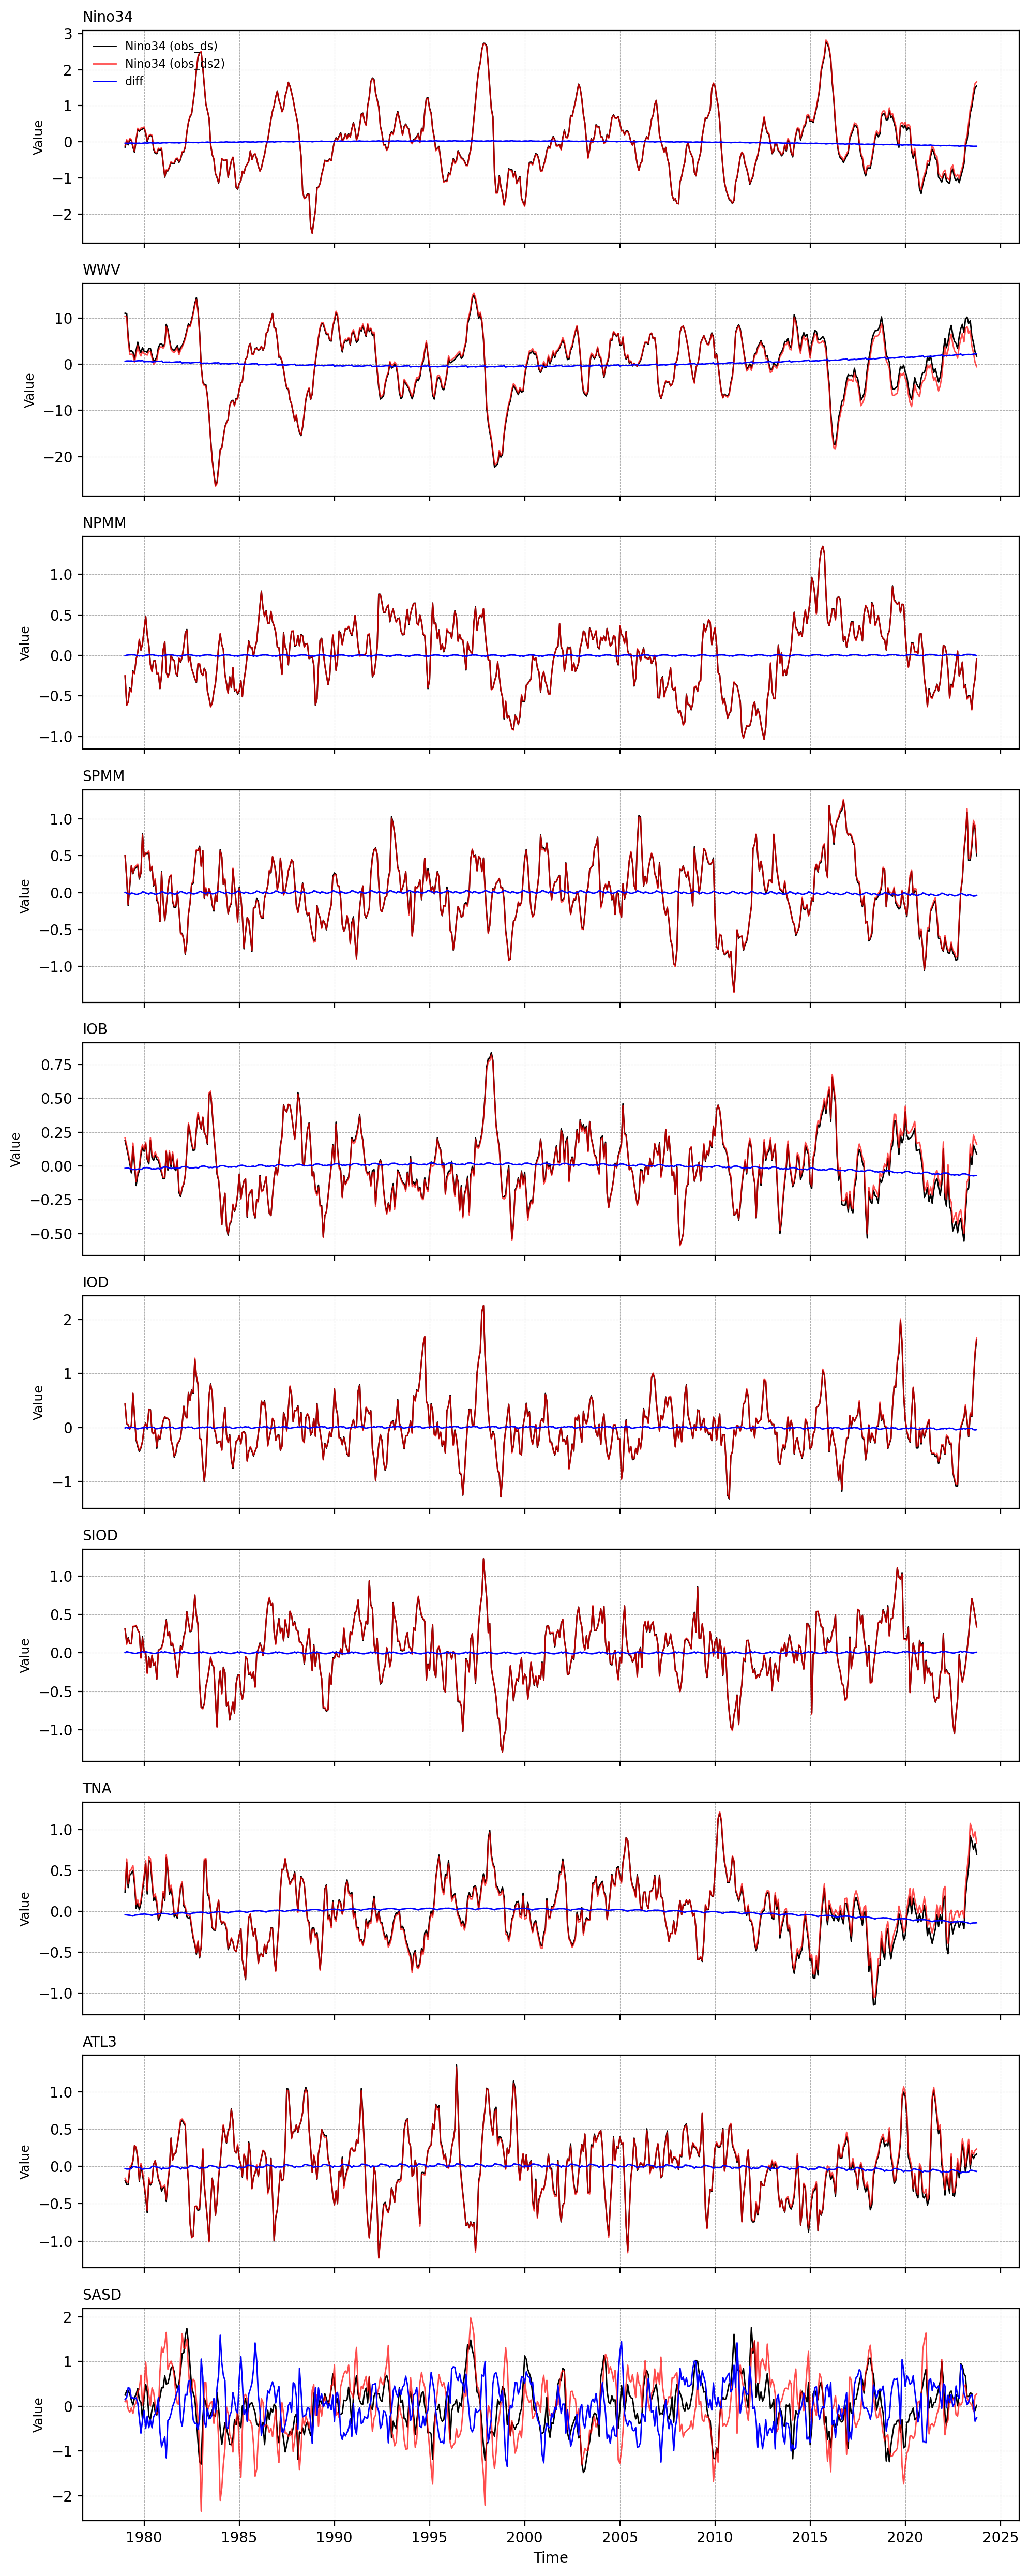

In [33]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# --- Variable mapping ---
mapping = {"WWV": "Hm", "SASD": "SASD1"}

# --- Variable list to compare ---
common_vars = [
    "Nino34", "WWV", "NPMM", "SPMM", "IOB",
    "IOD", "SIOD", "TNA", "ATL3", "SASD"
]

# --- Align datasets to common time range ---
common_time = slice(
    max(obs_ds.time.min().values, obs_ds2.time.min().values),
    min(obs_ds.time.max().values, obs_ds2.time.max().values)
)
obs1 = obs_ds.sel(time=common_time)
obs2 = obs_ds2.sel(time=common_time)

# --- Figure setup ---
nvar = len(common_vars)
fig, axes = plt.subplots(nvar, 1, figsize=(10, 2.5 * nvar), sharex=True)
if nvar == 1:
    axes = [axes]

for i, var in enumerate(common_vars):
    ax1 = axes[i]
    var2 = mapping.get(var, var)

    # Align time coordinates
    ds1, ds2 = xr.align(obs1[var], obs2[var2], join="inner")

    # --- Line plots for both datasets ---
    ax1.plot(ds1.time, ds1, label=f"{var} (obs_ds)", color="black", lw=1.0)
    ax1.plot(ds2.time, ds2, label=f"{var2} (obs_ds2)", color="red", lw=1.0, alpha=0.7)

    # --- Compute and plot difference ---
    diff = ds1 - ds2
    # ax2 = ax1.twinx()  # secondary y-axis (for difference bars)
    # ax2.bar(ds1.time, diff, width=25, color="blue", alpha=1, label="Difference")
    ax1.plot(ds1.time, diff, label='diff', color="blue", lw=1.0)
    # --- Titles, labels, grids ---
    ax1.set_title(var, fontsize=10, loc="left")
    ax1.grid(True, ls="--", lw=0.4)
    ax1.set_ylabel("Value", fontsize=9)
    # ax2.set_ylabel("Δ", rotation=0, fontsize=8, labelpad=12, color="gray")
    # ax2.tick_params(axis="y", colors="gray")

    # --- Legends ---
    if i == 0:
        ax1.legend(frameon=False, fontsize=8, loc="upper left")
        ax2.legend(frameon=False, fontsize=8, loc="upper right")

# --- Common labels ---
plt.xlabel("Time", fontsize=10)
plt.tight_layout()
plt.show()


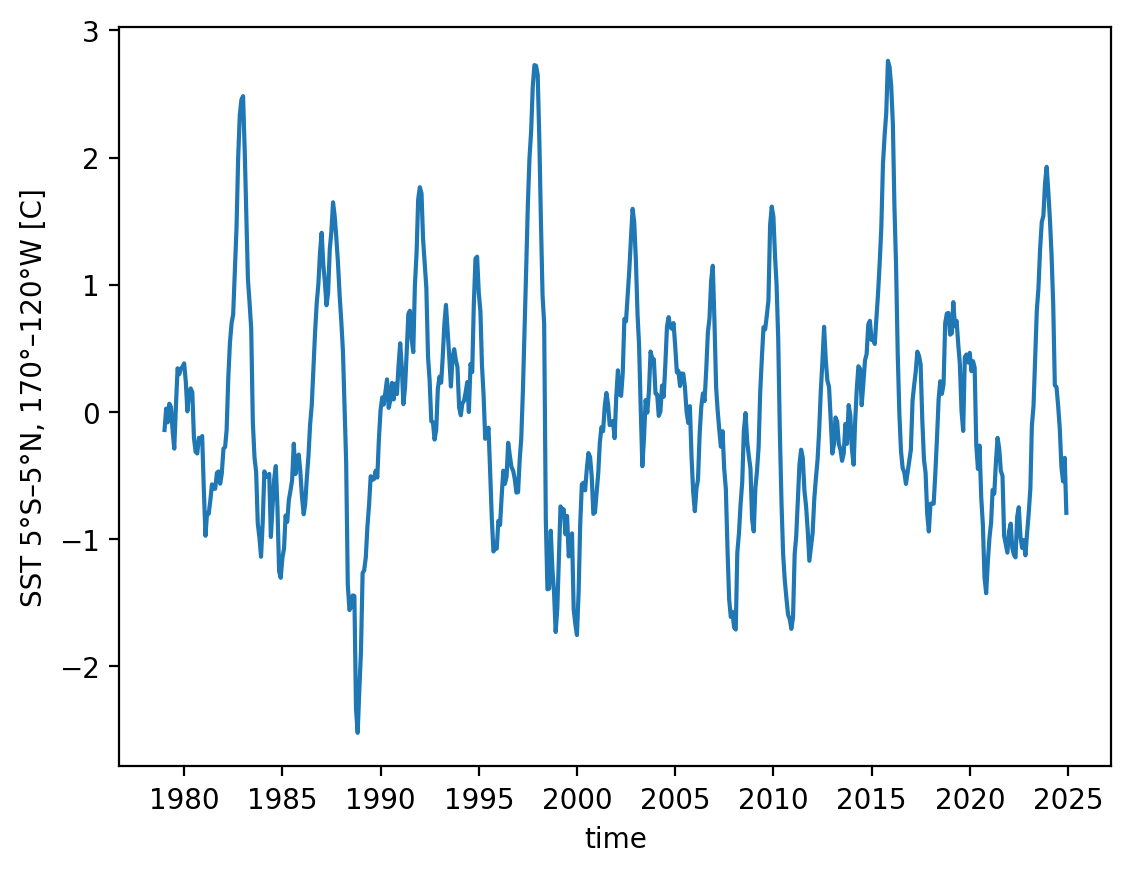

In [5]:
obs_ds.Nino34.plot()

In [6]:
slice_train = slice('1979-01', '2022-12')
slice_verif = slice('1979-01', '2022-12')

def calc_forecast_skill(fcst_ds, ref_ds, metric='acc', is_mv3=True, comparison="e2o", 
                        by_month=False, verify_periods=slice_verif):
    try:
        fcst_ds = fcst_ds.squeeze().drop('member')
    except:
        pass

    if is_mv3:
        fcst_ds = fcst_ds.rolling(init=3, center=True, min_periods=1).mean('init')
        ref_mv3 = ref_ds.rolling(time=3, center=True, min_periods=1).mean().dropna(dim='time')
    else:
        ref_mv3 = ref_ds

    hc_XRO = HindcastEnsemble(fcst_ds.sel(init=verify_periods))
    hc_XRO = hc_XRO.add_observations(ref_mv3)
    if by_month:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True, groupby='month')
    else:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True)
    try:
        del skill_XRO.attrs['skipna']
        skill_XRO = skill_XRO.drop('skill')
    except:
        pass

    for var in skill_XRO.data_vars:
        if var != 'model':
            skill_XRO[var].encoding['dtype'] = 'float32'
            skill_XRO[var].encoding['_FillValue'] = 1e20
    return skill_XRO

In [7]:
XRO_ac0 = XRO(ncycle=12, ac_order=0, is_forward=True)
XRO_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)
XRO_ac2 = XRO(ncycle=12, ac_order=2, is_forward=True)

model_XRO_ds = obs_ds[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD']]
model_NRO_ds = obs_ds[['Nino34', 'WWV']]

model_XRO_ds_3rm=model_XRO_ds.rolling(time=3, center=True, min_periods=1).mean(dim='time')
model_NRO_ds_3rm=model_NRO_ds.rolling(time=3, center=True, min_periods=1).mean(dim='time')

In [8]:


fit_XRO_train = XRO_ac1.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_outofsample = calc_forecast_skill(XRO_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_outofsample = calc_forecast_skill(XRO_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_NRO_train = XRO_ac1.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_NRO_train, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_outofsample = calc_forecast_skill(NRO_outofsample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)
rmse_NRO_outofsample = calc_forecast_skill(NRO_outofsample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

# fit_LRO_NPP = XRO_ac1.fit_matrix(model_NRO_ds, maskNT=[], maskNH=[])

fit_LRO_train = XRO_ac1.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_LRO_train, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_outofsample = calc_forecast_skill(LRO_outofsample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)
rmse_LRO_outofsample = calc_forecast_skill(LRO_outofsample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

In [9]:
acc_XRO_outofsample_1m = calc_forecast_skill(XRO_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=False, by_month=False, verify_periods=slice_verif)

In [10]:
slice_train = slice('1979-01', '2022-12')
slice_verif = slice('1979-01', '2022-12')

fit_XRO_train_3rm = XRO_ac1.fit_matrix(model_XRO_ds_3rm.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_outofsample_fcst_3rm = XRO_ac1.reforecast(fit_ds=fit_XRO_train_3rm, init_ds=model_XRO_ds_3rm.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_outofsample_3rm = calc_forecast_skill(XRO_outofsample_fcst_3rm, model_XRO_ds_3rm.sel(time=slice_verif), 
                                          metric='acc', is_mv3=False, by_month=False, verify_periods=slice_verif)
acc_XRO_outofsample_3rm_o1m = calc_forecast_skill(XRO_outofsample_fcst_3rm, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=False, by_month=False, verify_periods=slice_verif)
rmse_XRO_outofsample_3rm = calc_forecast_skill(XRO_outofsample_fcst_3rm, model_XRO_ds_3rm.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=False, by_month=False, verify_periods=slice_verif)

fit_NRO_train_3rm = XRO_ac1.fit_matrix(model_NRO_ds_3rm.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_outofsample_fcst_3rm = XRO_ac1.reforecast(fit_ds=fit_NRO_train_3rm, init_ds=model_NRO_ds_3rm.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_outofsample_3rm = calc_forecast_skill(NRO_outofsample_fcst_3rm, model_NRO_ds_3rm.sel(time=slice_verif), 
                                          metric='acc', is_mv3=False, by_month=False, verify_periods=slice_verif)
rmse_NRO_outofsample_3rm = calc_forecast_skill(NRO_outofsample_fcst_3rm, model_NRO_ds_3rm.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=False, by_month=False, verify_periods=slice_verif)

# fit_LRO_NPP = XRO_ac1.fit_matrix(model_NRO_ds, maskNT=[], maskNH=[])

fit_LRO_train_3rm = XRO_ac1.fit_matrix(model_NRO_ds_3rm.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_outofsample_fcst_3rm = XRO_ac1.reforecast(fit_ds=fit_LRO_train_3rm, init_ds=model_NRO_ds_3rm.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_outofsample_3rm = calc_forecast_skill(LRO_outofsample_fcst_3rm, model_NRO_ds_3rm.sel(time=slice_verif), 
                                          metric='acc', is_mv3=False, by_month=False, verify_periods=slice_verif)
rmse_LRO_outofsample_3rm = calc_forecast_skill(LRO_outofsample_fcst_3rm, model_NRO_ds_3rm.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=False, by_month=False, verify_periods=slice_verif)

In [11]:
fit_XRO_L_train = XRO_ac1.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=[], maskNH=[], maskb=[])

XRO_L_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_L_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_L_outofsample = calc_forecast_skill(XRO_L_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_L_outofsample = calc_forecast_skill(XRO_L_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_XRO_Q_train = XRO_ac1.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'], maskb=[])

XRO_Q_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_Q_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_Q_outofsample = calc_forecast_skill(XRO_Q_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_Q_outofsample = calc_forecast_skill(XRO_Q_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_XRO_C_train = XRO_ac1.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['TH'], maskNH=[], maskb=[])

XRO_C_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_C_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_C_outofsample = calc_forecast_skill(XRO_C_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_C_outofsample = calc_forecast_skill(XRO_C_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_XRO_QC_train = XRO_ac1.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=[])

XRO_QC_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_QC_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_QC_outofsample = calc_forecast_skill(XRO_QC_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_QC_outofsample = calc_forecast_skill(XRO_QC_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_XRO_I_train = XRO_ac1.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_I_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_I_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_I_outofsample = calc_forecast_skill(XRO_I_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_I_outofsample = calc_forecast_skill(XRO_I_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

In [12]:
slice_train = slice('1979-01', '2022-12')
slice_verif = slice('1979-01', '2022-12')

fit_XRO_train2 = XRO_ac2.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_XRO_train2, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_outofsample2 = calc_forecast_skill(XRO_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_outofsample2 = calc_forecast_skill(XRO_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_NRO_train2 = XRO_ac2.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_NRO_train2, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_outofsample2 = calc_forecast_skill(NRO_outofsample_fcst2, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)
rmse_NRO_outofsample2 = calc_forecast_skill(NRO_outofsample_fcst2, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

# fit_LRO_NPP = XRO_ac2.fit_matrix(model_NRO_ds, maskNT=[], maskNH=[])

fit_LRO_train2 = XRO_ac2.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_LRO_train2, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_outofsample2 = calc_forecast_skill(LRO_outofsample_fcst2, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)
rmse_LRO_outofsample2 = calc_forecast_skill(LRO_outofsample_fcst2, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

In [13]:
fit_XRO_L_train2 = XRO_ac2.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=[], maskNH=[], maskb=[])

XRO_L_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_XRO_L_train2, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_L_outofsample2 = calc_forecast_skill(XRO_L_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_L_outofsample2 = calc_forecast_skill(XRO_L_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_XRO_Q_train2 = XRO_ac2.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'], maskb=[])

XRO_Q_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_XRO_Q_train2, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_Q_outofsample2 = calc_forecast_skill(XRO_Q_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_Q_outofsample2 = calc_forecast_skill(XRO_Q_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_XRO_C_train2 = XRO_ac2.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['TH'], maskNH=[], maskb=[])

XRO_C_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_XRO_C_train2, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_C_outofsample2 = calc_forecast_skill(XRO_C_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_C_outofsample2 = calc_forecast_skill(XRO_C_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_XRO_QC_train2 = XRO_ac2.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=[])

XRO_QC_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_XRO_QC_train2, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_QC_outofsample2 = calc_forecast_skill(XRO_QC_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_QC_outofsample2 = calc_forecast_skill(XRO_QC_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_XRO_I_train2 = XRO_ac2.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_I_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_XRO_I_train2, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_I_outofsample2 = calc_forecast_skill(XRO_I_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_I_outofsample2 = calc_forecast_skill(XRO_I_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

In [14]:
slice_train = slice('1979-01', '2022-12')
slice_verif = slice('1979-01', '2022-12')

fit_XRO_train0 = XRO_ac0.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_XRO_train0, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_outofsample0 = calc_forecast_skill(XRO_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_outofsample0 = calc_forecast_skill(XRO_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_NRO_train0 = XRO_ac0.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_NRO_train0, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_outofsample0 = calc_forecast_skill(NRO_outofsample_fcst0, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)
rmse_NRO_outofsample0 = calc_forecast_skill(NRO_outofsample_fcst0, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

# fit_LRO_NPP = XRO_ac0.fit_matrix(model_NRO_ds, maskNT=[], maskNH=[])

fit_LRO_train0 = XRO_ac0.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_LRO_train0, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_outofsample0 = calc_forecast_skill(LRO_outofsample_fcst0, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)
rmse_LRO_outofsample0 = calc_forecast_skill(LRO_outofsample_fcst0, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

In [15]:
fit_XRO_L_train0 = XRO_ac0.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=[], maskNH=[], maskb=[])

XRO_L_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_XRO_L_train0, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_L_outofsample0 = calc_forecast_skill(XRO_L_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_L_outofsample0 = calc_forecast_skill(XRO_L_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_XRO_Q_train0 = XRO_ac0.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'], maskb=[])

XRO_Q_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_XRO_Q_train0, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_Q_outofsample0 = calc_forecast_skill(XRO_Q_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_Q_outofsample0 = calc_forecast_skill(XRO_Q_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_XRO_C_train0 = XRO_ac0.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['TH'], maskNH=[], maskb=[])

XRO_C_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_XRO_C_train0, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_C_outofsample0 = calc_forecast_skill(XRO_C_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_C_outofsample0 = calc_forecast_skill(XRO_C_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_XRO_QC_train0 = XRO_ac0.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=[])

XRO_QC_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_XRO_QC_train0, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_QC_outofsample0 = calc_forecast_skill(XRO_QC_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_QC_outofsample0 = calc_forecast_skill(XRO_QC_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_XRO_I_train0 = XRO_ac0.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_I_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_XRO_I_train0, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_I_outofsample0 = calc_forecast_skill(XRO_I_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_I_outofsample0 = calc_forecast_skill(XRO_I_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

In [16]:
slice_train = slice('1979-01', '2022-12')
slice_verif = slice('1979-01', '2022-12')

fit_XRO_train = XRO_ac2.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_insample_fcst = XRO_ac2.reforecast(fit_ds=fit_XRO_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_insample = calc_forecast_skill(XRO_insample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_insample = calc_forecast_skill(XRO_insample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_NRO_train = XRO_ac2.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_insample_fcst = XRO_ac2.reforecast(fit_ds=fit_NRO_train, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_insample = calc_forecast_skill(NRO_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)
rmse_NRO_insample = calc_forecast_skill(NRO_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

# fit_LRO_NPP = XRO_ac1.fit_matrix(model_NRO_ds, maskNT=[], maskNH=[])

fit_LRO_train = XRO_ac2.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_insample_fcst = XRO_ac2.reforecast(fit_ds=fit_LRO_train, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_insample = calc_forecast_skill(LRO_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)
rmse_LRO_insample = calc_forecast_skill(LRO_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

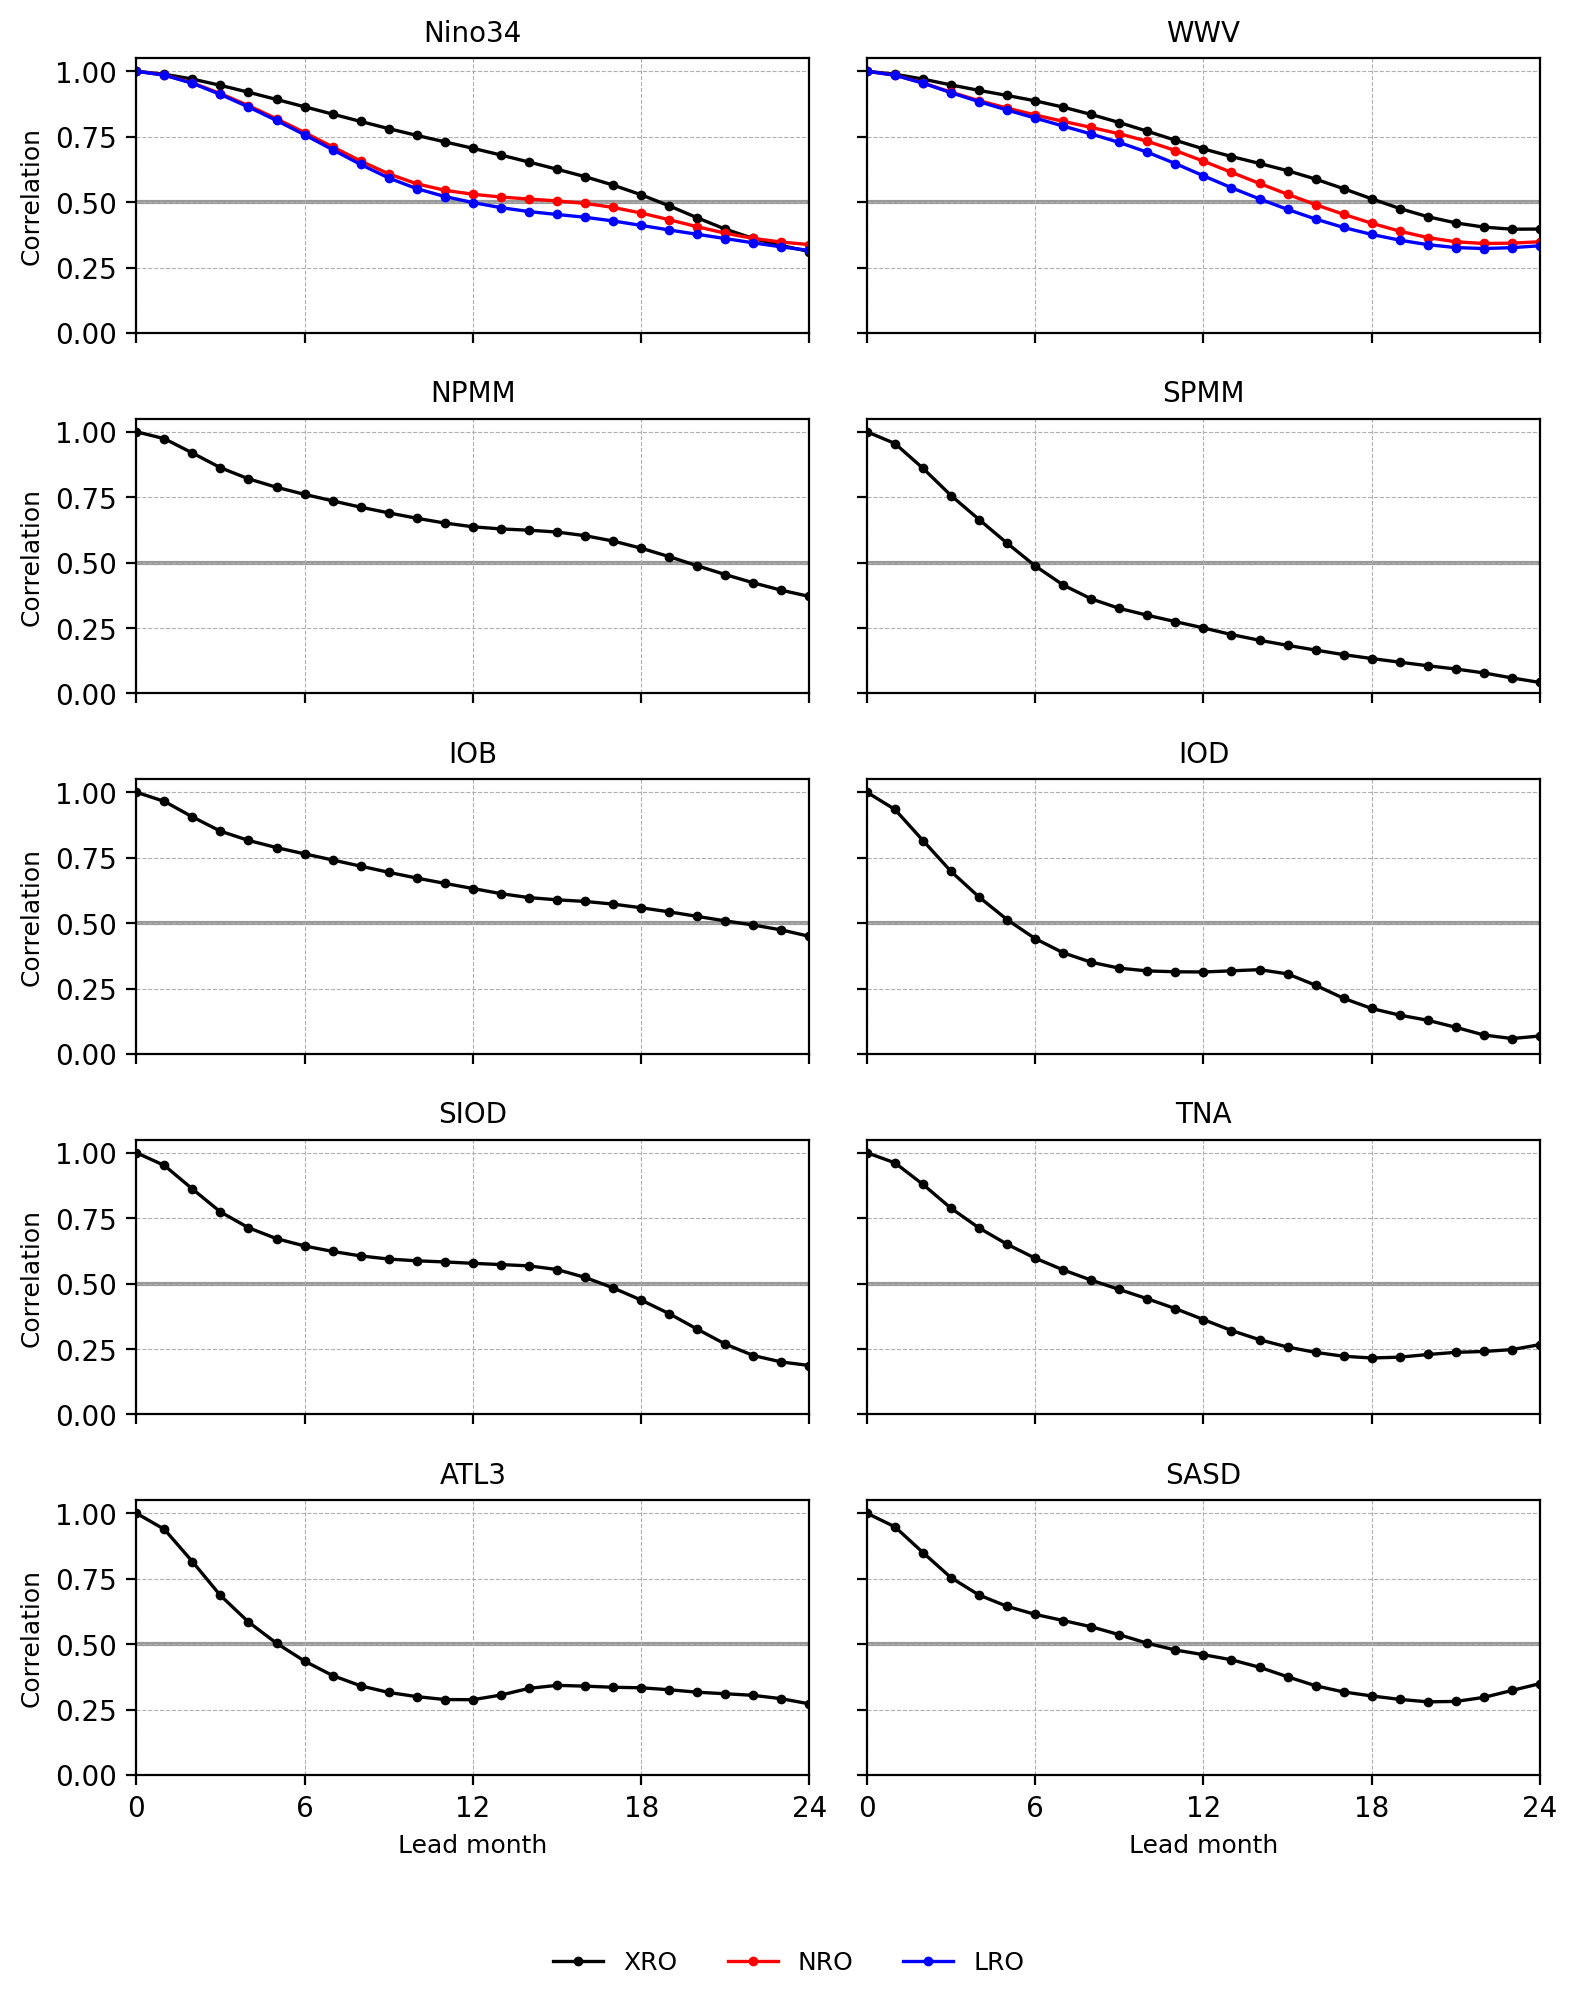

In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# Inputs (assumed to be loaded)
# ------------------------------------------------------------
skill_sets = {
    "XRO": acc_XRO_insample,
    "NRO": acc_NRO_insample,
    "LRO": acc_LRO_insample,
}

# Variable list (order)
var_list = ["Nino34", "WWV", "NPMM", "SPMM", "IOB", "IOD", "SIOD", "TNA", "ATL3", "SASD"]
leads = skill_sets["XRO"].lead.values

# ------------------------------------------------------------
# Colors and labels
# ------------------------------------------------------------
colors = {
    "XRO": "black",
    "NRO": "red",
    "LRO": "blue",
}
labels = {
    "XRO": "XRO",
    "NRO": "NRO",
    "LRO": "LRO",
}

# ------------------------------------------------------------
# Plot setup
# ------------------------------------------------------------
nvar = len(var_list)
ncol = 2
nrow = int(np.ceil(nvar / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(8, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, var in enumerate(var_list):
    ax = axes[i]
    
    # --- Plot benchmark line ---
    ax.axhline(0.5, color='gray', lw=1.5, alpha=0.8, zorder=0)
    
    # --- Plot skill curves ---
    for key, ds in skill_sets.items():
        if var not in ds:
            continue
        y = ds[var]
        ax.plot(
            leads, y,
            color=colors[key],
            marker="o",
            markersize=2.5,
            lw=1.2,
            label=labels[key]
        )
    
    ax.set_title(var, fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, leads[-1])
    
    # --- Grid setup ---
    ax.set_xticks(np.arange(0, leads[-1] + 1, 6))
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.grid(True, ls="--", lw=0.4)
    
    if i >= (nrow - 1) * ncol:
        ax.set_xlabel("Lead month", fontsize=9)
    if i % ncol == 0:
        ax.set_ylabel("Correlation", fontsize=9)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ------------------------------------------------------------
# Legend and layout
# ------------------------------------------------------------
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc="lower center", ncol=3, frameon=False, fontsize=9)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


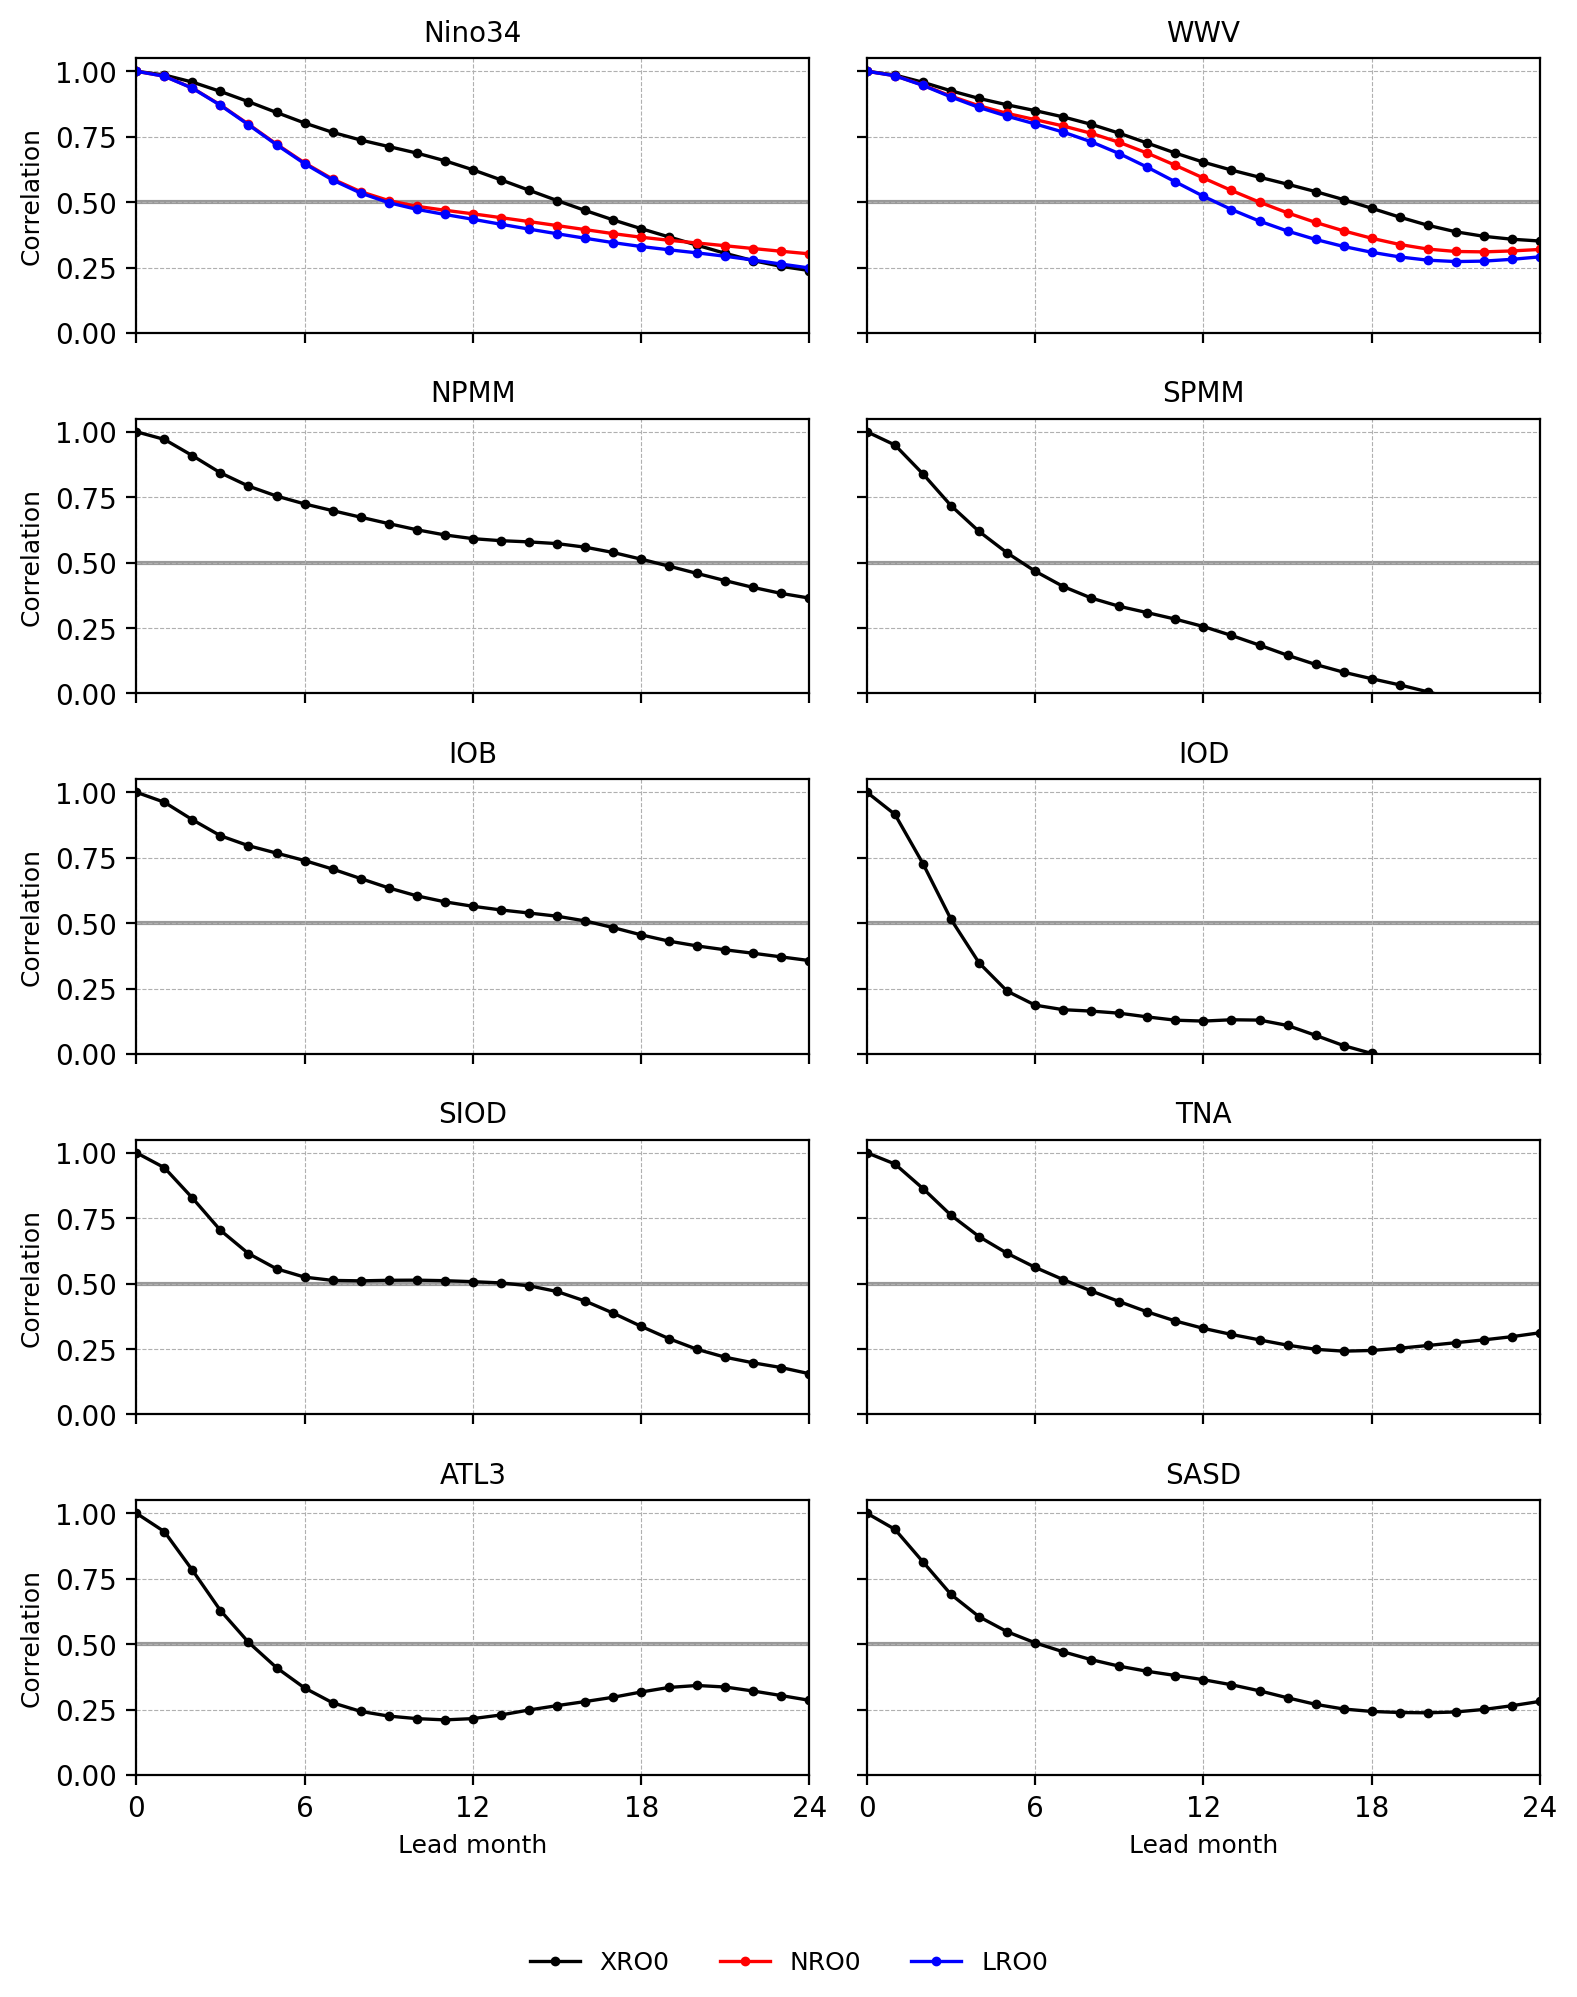

In [18]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# Inputs (assumed to be loaded)
# ------------------------------------------------------------
skill_sets = {
    "XRO0": acc_XRO_outofsample0,
    "NRO0": acc_NRO_outofsample0,
    "LRO0": acc_LRO_outofsample0,
}

# Variable list (order)
var_list = ["Nino34", "WWV", "NPMM", "SPMM", "IOB", "IOD", "SIOD", "TNA", "ATL3", "SASD"]
leads = skill_sets["XRO0"].lead.values

# ------------------------------------------------------------
# Colors and labels
# ------------------------------------------------------------
colors = {
    "XRO0": "black",
    "NRO0": "red",
    "LRO0": "blue",
}
labels = {
    "XRO0": "XRO0",
    "NRO0": "NRO0",
    "LRO0": "LRO0",
}

# ------------------------------------------------------------
# Plot setup
# ------------------------------------------------------------
nvar = len(var_list)
ncol = 2
nrow = int(np.ceil(nvar / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(8, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, var in enumerate(var_list):
    ax = axes[i]
    
    # --- Plot benchmark line ---
    ax.axhline(0.5, color='gray', lw=1.5, alpha=0.8, zorder=0)
    
    # --- Plot skill curves ---
    for key, ds in skill_sets.items():
        if var not in ds:
            continue
        y = ds[var]
        ax.plot(
            leads, y,
            color=colors[key],
            marker="o",
            markersize=2.5,
            lw=1.2,
            label=labels[key]
        )
    
    ax.set_title(var, fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, leads[-1])
    
    # --- Grid setup ---
    ax.set_xticks(np.arange(0, leads[-1] + 1, 6))
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.grid(True, ls="--", lw=0.4)
    
    if i >= (nrow - 1) * ncol:
        ax.set_xlabel("Lead month", fontsize=9)
    if i % ncol == 0:
        ax.set_ylabel("Correlation", fontsize=9)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ------------------------------------------------------------
# Legend and layout
# ------------------------------------------------------------
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc="lower center", ncol=3, frameon=False, fontsize=9)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


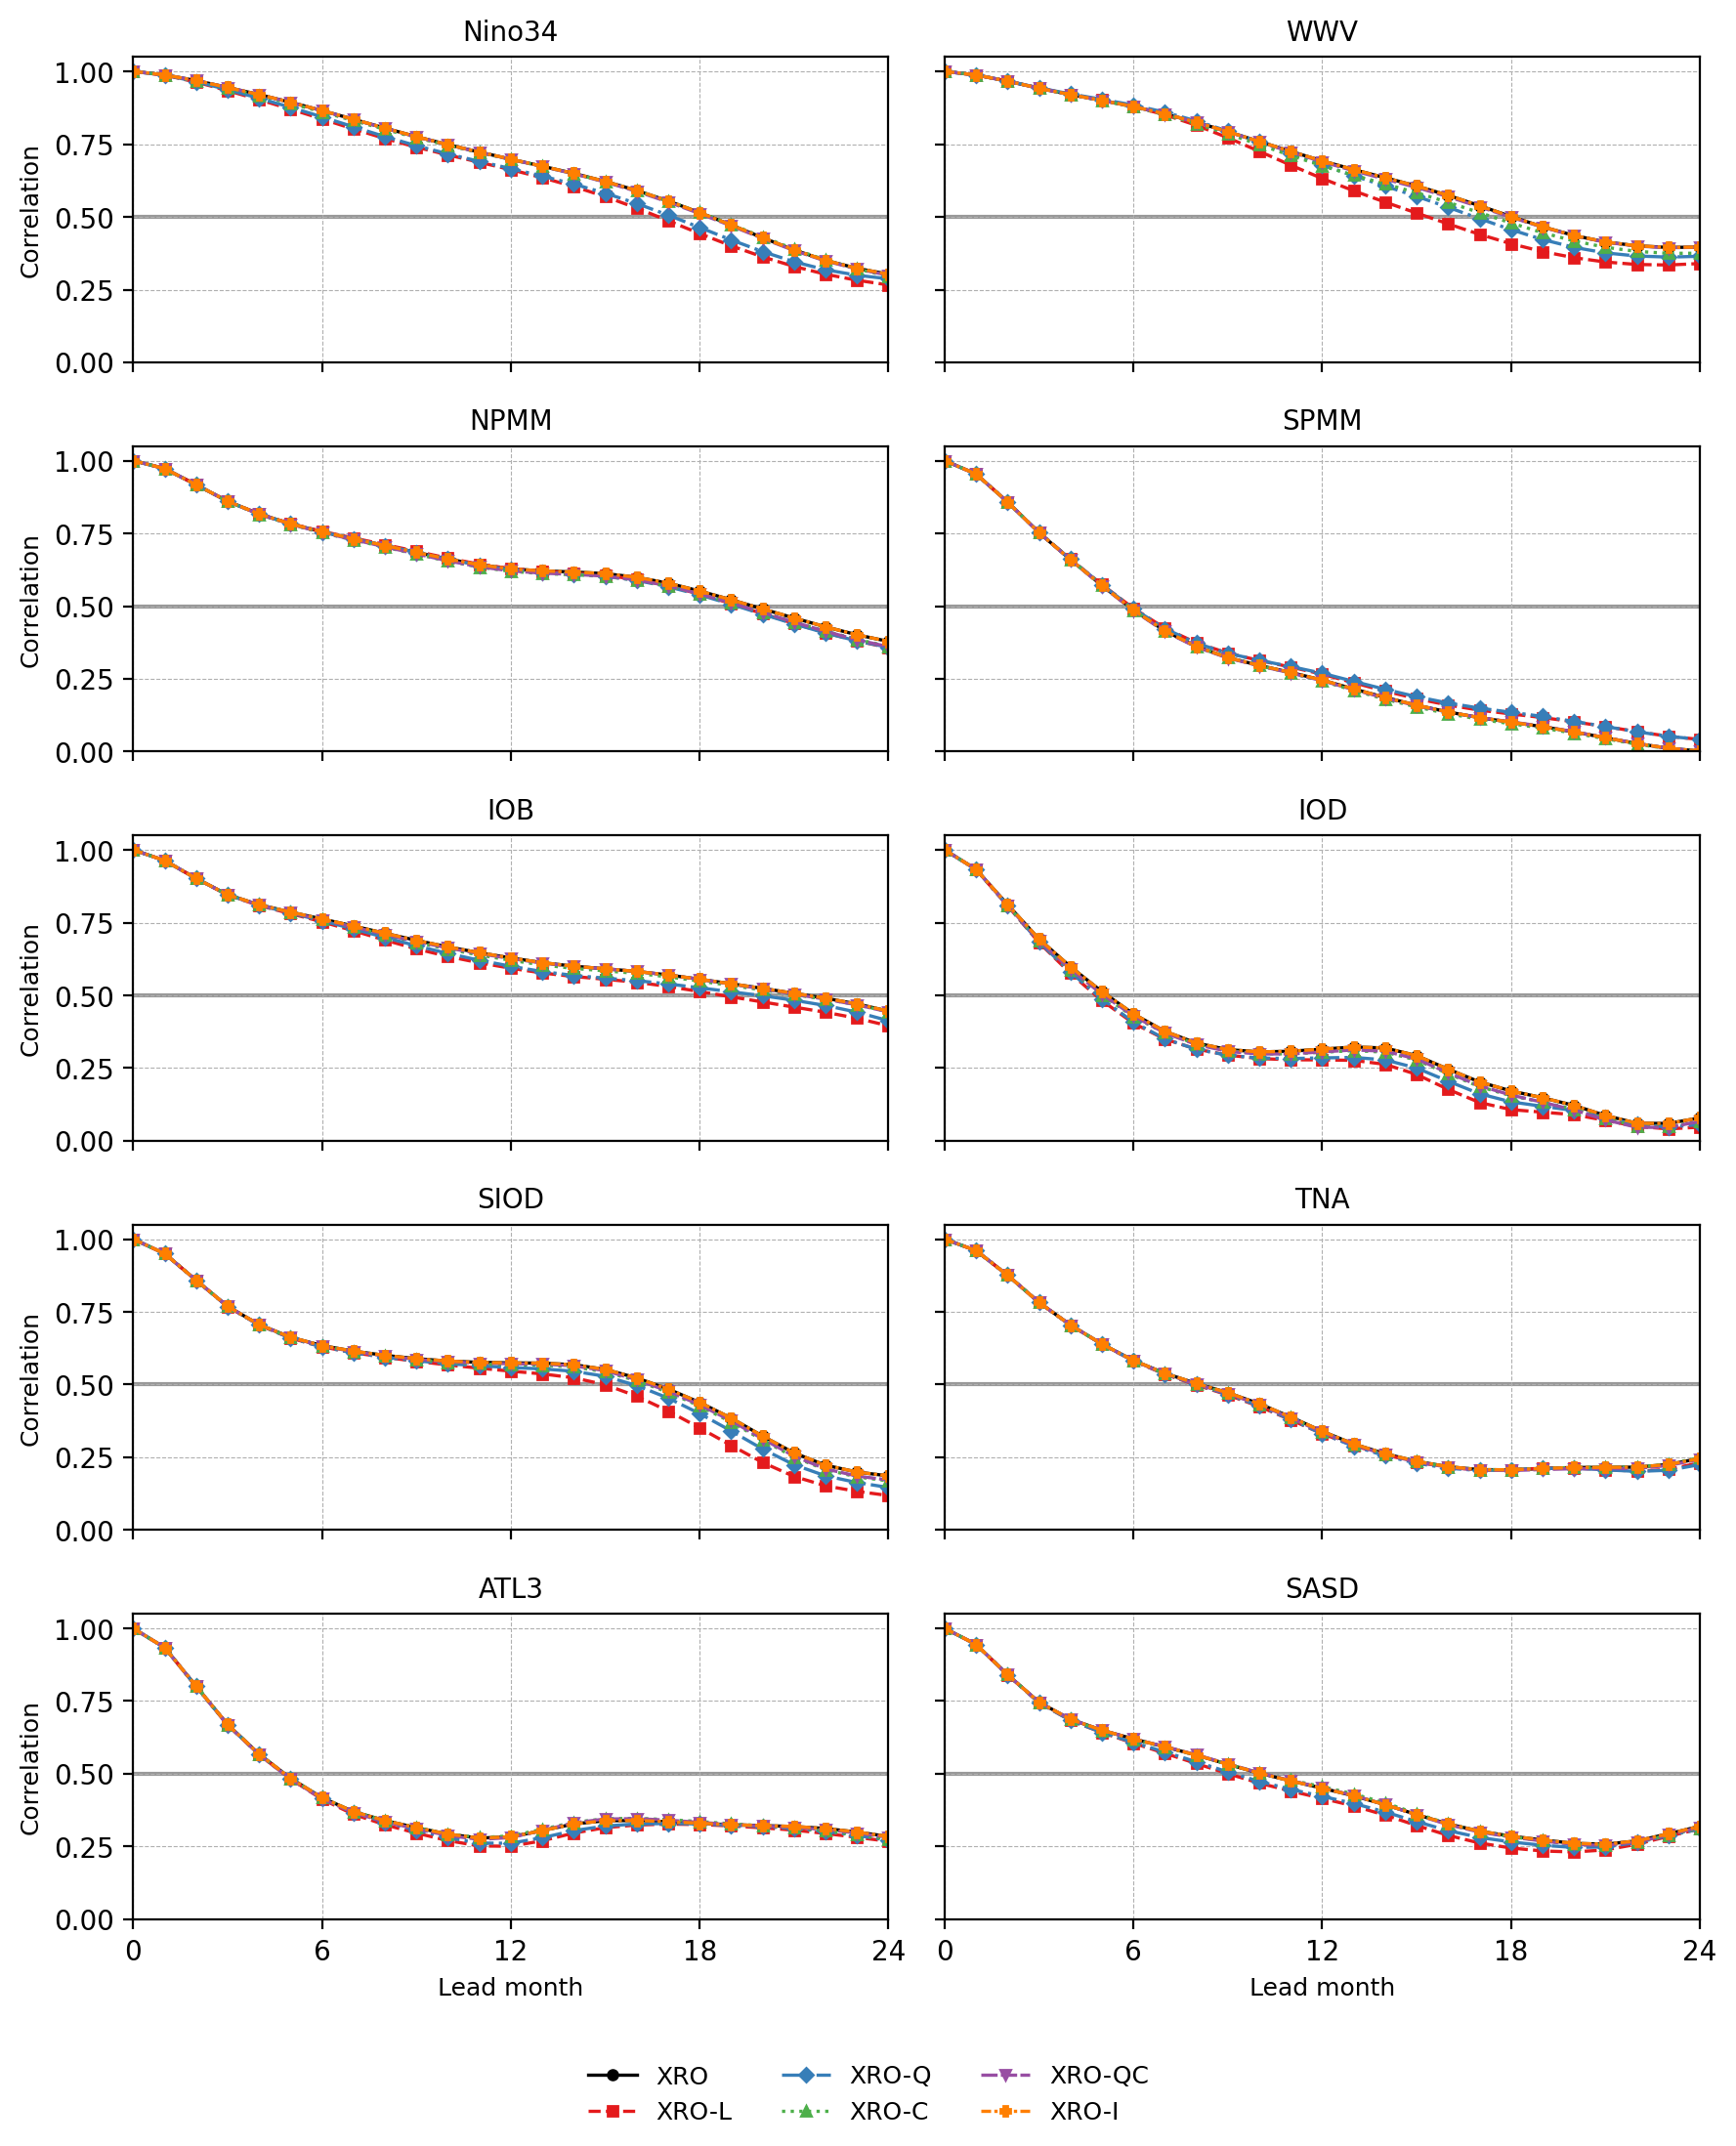

In [19]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

skill_sets = {
    "XRO": acc_XRO_outofsample,
    "XRO_L": acc_XRO_L_outofsample,
    "XRO_Q": acc_XRO_Q_outofsample,
    "XRO_C": acc_XRO_C_outofsample,
    "XRO_QC": acc_XRO_QC_outofsample,
    "XRO_I": acc_XRO_I_outofsample,
}

var_list = ["Nino34", "WWV", "NPMM", "SPMM", "IOB", "IOD", "SIOD", "TNA", "ATL3", "SASD"]
leads = skill_sets["XRO"].lead.values

# --- colors, labels, markers, linestyles ---
colors = {
    "XRO": "black",
    "XRO_L": "#e41a1c",
    "XRO_Q": "#377eb8",
    "XRO_C": "#4daf4a",
    "XRO_QC": "#984ea3",
    "XRO_I": "#ff7f00",
}
labels = {
    "XRO": "XRO",
    "XRO_L": "XRO-L",
    "XRO_Q": "XRO-Q",
    "XRO_C": "XRO-C",
    "XRO_QC": "XRO-QC",
    "XRO_I": "XRO-I",
}
markers = ["o", "s", "D", "^", "v", "P"]
linestyles = ["-", "--", "-.", ":", (0, (5, 1)), (0, (3, 1, 1, 1))]  # 다양한 패턴

# --- figure layout ---
nvar = len(var_list)
ncol = 2
nrow = int(np.ceil(nvar / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(9, 11), sharex=True, sharey=True)
axes = axes.flatten()

for i, var in enumerate(var_list):
    ax = axes[i]
    
    # --- benchmark line ---
    ax.axhline(0.5, color='gray', lw=1.5, alpha=0.8, zorder=0)
    
    # --- skill curves ---
    for j, (key, ds) in enumerate(skill_sets.items()):
        if var not in ds:
            continue
        y = ds[var]
        ax.plot(
            leads, y,
            color=colors[key],
            marker=markers[j % len(markers)],
            linestyle=linestyles[j % len(linestyles)],
            markersize=3.5,
            lw=1.2,
            label=labels[key],
        )
    
    ax.set_title(var, fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, leads[-1])
    ax.set_xticks(np.arange(0, leads[-1] + 1, 6))
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.grid(True, ls="--", lw=0.4)
    
    if i >= (nrow - 1) * ncol:
        ax.set_xlabel("Lead month", fontsize=9)
    if i % ncol == 0:
        ax.set_ylabel("Correlation", fontsize=9)

# --- remove empty subplots ---
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# --- legend ---
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc="lower center", ncol=3, frameon=False, fontsize=9)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


In [20]:
import os
import xarray as xr

# ------------------------------------------------------------
# Define datasets to save
# ------------------------------------------------------------
datasets_to_save = {
    "XRO": {"fit": fit_XRO_train, "acc": acc_XRO_outofsample},
    "NRO": {"fit": fit_NRO_train, "acc": acc_NRO_outofsample},
    "LRO": {"fit": fit_LRO_train, "acc": acc_LRO_outofsample},
}

# Output directory
OUT_DIR = "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/fit_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# Save loop
# ------------------------------------------------------------
for key, ds_dict in datasets_to_save.items():
    for dtype, ds in ds_dict.items():
        fname = f"{dtype}_{key}_train.nc"
        fpath = os.path.join(OUT_DIR, fname)

        # Ensure dataset is clean and loaded
        ds = ds.load()
        ds = ds.map(lambda x: x.astype(float) if x.dtype.kind in "iuf" else x)

        print(f"Saving: {fpath}")
        ds.to_netcdf(fpath)


Saving: /mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/fit_outputs/fit_XRO_train.nc
Saving: /mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/fit_outputs/acc_XRO_train.nc
Saving: /mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/fit_outputs/fit_NRO_train.nc
Saving: /mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/fit_outputs/acc_NRO_train.nc
Saving: /mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/fit_outputs/fit_LRO_train.nc
Saving: /mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/fit_outputs/acc_LRO_train.nc
